source: https://www.digitalocean.com/community/tutorials/a-guide-to-time-series-forecasting-with-arima-in-python-3

In [1]:
import warnings
import itertools
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

C:\Users\dhruv.aggarwal\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
data = sm.datasets.co2.load_pandas()
co2 = data.data
print("Data imported")

Data imported


a dataset called "Atmospheric CO2 from Continuous Air Samples at Mauna Loa Observatory, Hawaii, U.S.A.," which collected CO2 samples from March 1958 to December 2001. 

In [3]:
co2.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2284 entries, 1958-03-29 to 2001-12-29
Freq: W-SAT
Data columns (total 1 columns):
co2    2225 non-null float64
dtypes: float64(1)
memory usage: 35.7 KB


 the dates have been set as the index of our pandas DataFrame. When working with time-series data in Python we should ensure that dates are used as an index, so make sure to always check for that, which we can do by running the following:

In [4]:
co2.index

DatetimeIndex(['1958-03-29', '1958-04-05', '1958-04-12', '1958-04-19',
               '1958-04-26', '1958-05-03', '1958-05-10', '1958-05-17',
               '1958-05-24', '1958-05-31',
               ...
               '2001-10-27', '2001-11-03', '2001-11-10', '2001-11-17',
               '2001-11-24', '2001-12-01', '2001-12-08', '2001-12-15',
               '2001-12-22', '2001-12-29'],
              dtype='datetime64[ns]', length=2284, freq='W-SAT')

The dtype=datetime[ns] field confirms that our index is made of date stamp objects, while length=2284 and freq='W-SAT' tells us that we have 2,284 weekly date stamps starting on Saturdays.

Weekly data can be tricky to work with, so let's use the monthly averages of our time-series instead. 

This can be obtained by using the convenient resample function, which allows us to group the time-series into buckets (1 month), apply a function on each group (mean), and combine the result (one row per group).

In [5]:
y = co2['co2'].resample('MS').mean()

In [6]:
y.head()

1958-03-01    316.100000
1958-04-01    317.200000
1958-05-01    317.433333
1958-06-01           NaN
1958-07-01    315.625000
Freq: MS, Name: co2, dtype: float64

In [7]:
y['1990']#only 1990

1990-01-01    353.650
1990-02-01    354.650
1990-03-01    355.480
1990-04-01    356.175
1990-05-01    357.075
1990-06-01    356.080
1990-07-01    354.675
1990-08-01    352.900
1990-09-01    350.940
1990-10-01    351.225
1990-11-01    352.700
1990-12-01    354.140
Freq: MS, Name: co2, dtype: float64

In [8]:
#y['1990':] 
#1990 onwards

In [9]:
y['1995-10-01':'1996-10-01']

1995-10-01    357.850
1995-11-01    359.475
1995-12-01    360.700
1996-01-01    362.025
1996-02-01    363.175
1996-03-01    364.060
1996-04-01    364.700
1996-05-01    365.325
1996-06-01    364.880
1996-07-01    363.475
1996-08-01    361.320
1996-09-01    359.400
1996-10-01    359.625
Freq: MS, Name: co2, dtype: float64

In [10]:
y.isnull().sum()

5

In [11]:
y = y.fillna(y.bfill())

In [12]:
y.isnull().sum()

0

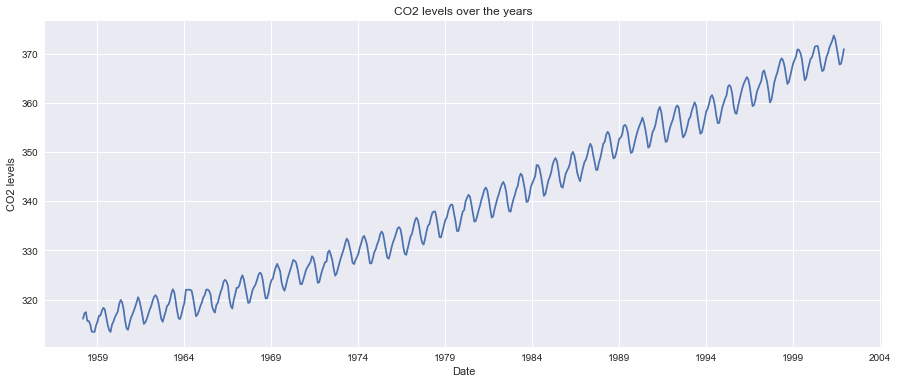

In [13]:
y.plot(figsize =(15,6))
plt.xlabel('Date')
plt.ylabel('CO2 levels')
plt.title('CO2 levels over the years')        
plt.show()

The time-series has an obvious seasonality pattern, as well as an overall increasing trend

We can also visualize our data using a method called time-series decomposition. 

Time series decomposition allows us to decompose our time series into three distinct components: trend, seasonality, and noise.

seasonality: does the data display a clear periodic pattern?

trend: does the data follow a consistent upwards or downward slope?

noise: are there any outlier points or missing values that are not consistent with the rest of the data?

statsmodels provides the convenient seasonal_decompose function to perform seasonal decomposition out of the box.

By default, seasonal_decompose returns a figure of relatively small size, so the first two lines of this code chunk ensure that the output figure is large enough for us to visualize.

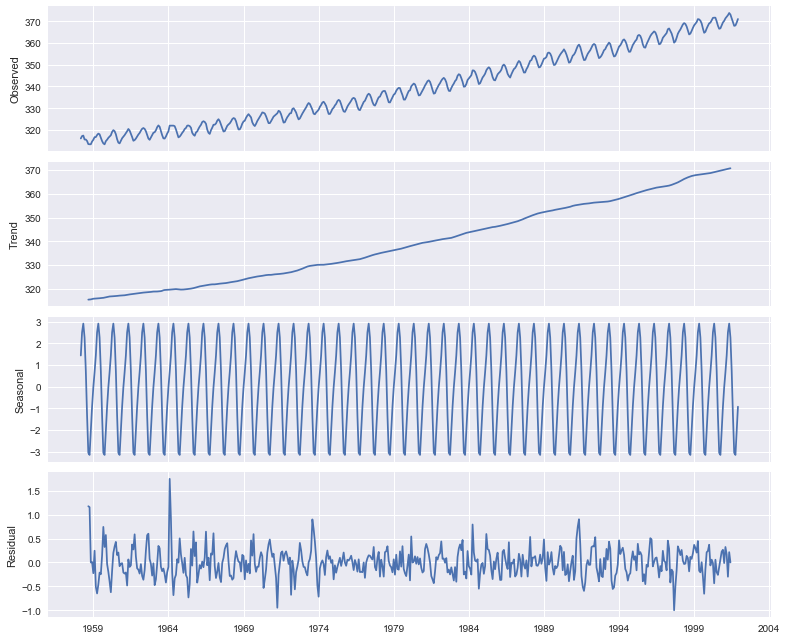

In [14]:
from pylab import rcParams
rcParams['figure.figsize'] = 11,9

decomposition = sm.tsa.seasonal_decompose(y , model = 'additive')
fig = decomposition.plot()
plt.show()

The plot above clearly shows the upwards trend of our data, along with its yearly seasonality. 

These can be used to understand the structure of our time-series. 

The intuition behind time-series decomposition is important, as many forecasting methods build upon this concept of structured decomposition to produce forecasts.

There are three distinct integers (p, d, q) that are used to parametrize ARIMA models.

p is the auto-regressive part of the model. It allows us to incorporate the effect of past values into our model.
it is likely to be warm tomorrow if it has been warm the past 3 days.


d is the integrated part of the model. This includes terms in the model that incorporate the amount of differencing (i.e. the number of past time points to subtract from the current value) to apply to the time series.
it is likely to be same temperature tomorrow if the difference in temperature in the last three days has been very small.
 

q is the moving average part of the model. This allows us to set the error of our model as a linear combination of the error values observed at previous time points in the past.


we make use of the seasonal ARIMA, which is denoted as ARIMA(p,d,q)(P,D,Q)s. Here, (p, d, q) are the non-seasonal parameters described above, while (P, D, Q) follow the same definition but are applied to the seasonal component of the time series. The term s is the periodicity of the time series (4 for quarterly periods, 12 for yearly periods, etc.).

Python code to programmatically select the optimal parameter values for our ARIMA(p,d,q)(P,D,Q)s time series model.

We will use a "grid search" to iteratively explore different combinations of parameters. 

For each combination of parameters, we fit a new seasonal ARIMA model with the SARIMAX() function from the statsmodels module and assess its overall quality.

In [15]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


We can now use the triplets of parameters defined above to automate the process of training and evaluating ARIMA models on different combinations. 

In Statistics and Machine Learning, this process is known as grid search (or hyperparameter optimization) for model selection.

We will use the AIC (Akaike Information Criterion) value, which is conveniently returned with ARIMA models fitted using statsmodels. 

The AIC measures how well a model fits the data while taking into account the overall complexity of the model. 

A model that fits the data very well while using lots of features will be assigned a larger AIC score than a model that uses fewer features to achieve the same goodness-of-fit. 

Therefore, we are interested in finding the model that yields the lowest AIC value.

The code chunk below iterates through combinations of parameters and uses the SARIMAX function from statsmodels to fit the corresponding Seasonal ARIMA model. 

Here, the order argument specifies the (p, d, q) parameters, while the seasonal_order argument specifies the (P, D, Q, S) seasonal component of the Seasonal ARIMA model. 

After fitting each SARIMAX()model, the code prints out its respective AIC score.

In [16]:
warnings.filterwarnings("ignore") # specify to ignore warning messages

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:6787.343624036737
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:1596.7111727641156
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:1058.9388921320026
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:1056.287855610497
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:1361.6578978072075
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:1044.7647912934656
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:6881.048755126321
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:6072.662327718421
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:1379.1941067330986
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:1241.4174716776201
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:1084.9453872064087
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:780.4313909247412
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:1119.5957893630987
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:807.0912988821106
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:1240.2211199194085
ARIMA(0, 1, 0)x(0, 1, 1, 12)12 - AIC:337.7938545681309
ARIMA(0, 1, 0)x(1, 0, 0, 12)12 - AIC:619.9501759055394
ARIMA(0, 1, 0)x(1, 0, 1, 12)12 - AIC:376.92837600008676


Because some parameter combinations may lead to numerical misspecifications, we explicitly disabled warning messages in order to avoid an overload of warning messages. 

These misspecifications can also lead to errors and throw an exception, so we make sure to catch these exceptions and ignore the parameter combinations that cause these issues.

The output of our code suggests that SARIMAX(1, 1, 1)x(1, 1, 1, 12) yields the lowest AIC value of 277.78. We should therefore consider this to be optimal option out of all the models we have considered.

#### Step 5 — Fitting an ARIMA Time Series Model

Using grid search, we have identified the set of parameters that produces the best fitting model to our time series data. We can proceed to analyze this particular model in more depth.

We'll start by plugging the optimal parameter values into a new SARIMAX model:

In [17]:
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3180      0.092      3.444      0.001       0.137       0.499
ma.L1         -0.6255      0.076     -8.177      0.000      -0.775      -0.476
ar.S.L12       0.0010      0.001      1.732      0.083      -0.000       0.002
ma.S.L12      -0.8766      0.026    -33.754      0.000      -0.927      -0.826
sigma2         0.0971      0.004     22.637      0.000       0.089       0.106


The summary attribute that results from the output of SARIMAX returns a significant amount of information, but we'll focus our attention on the table of coefficients. 


The coef column shows the weight (i.e. importance) of each feature and how each one impacts the time series. 


The P>|z| column informs us of the significance of each feature weight. 


Here, each weight has a p-value lower or close to 0.05, so it is reasonable to retain all of them in our model.

The plot_diagnostics object allows us to quickly generate model diagnostics and investigate for any unusual behavior.

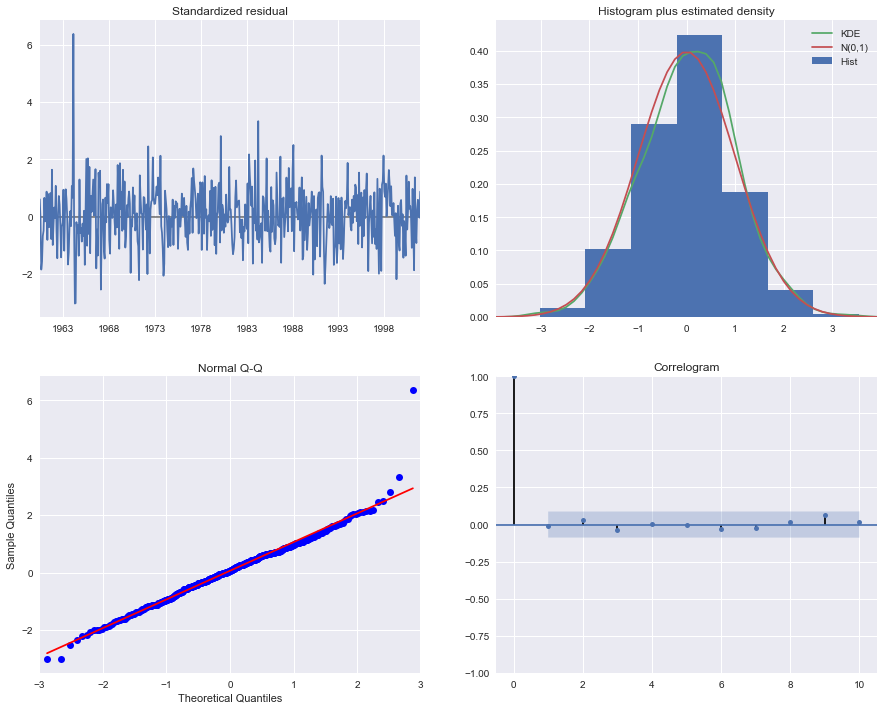

In [18]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

Our primary concern is to ensure that the residuals of our model are uncorrelated and normally distributed with zero-mean. 

If the seasonal ARIMA model does not satisfy these properties, it is a good indication that it can be further improved.




In the top right plot, we see that the red KDE line follows closely with the N(0,1) line (where N(0,1)) is the standard notation for a normal distribution with mean 0 and standard deviation of 1). 

This is a good indication that the residuals are normally distributed.


The qq-plot on the bottom left shows that the ordered distribution of residuals (blue dots) follows the linear trend of the samples taken from a standard normal distribution with N(0, 1). 

Again, this is a strong indication that the residuals are normally distributed.


The residuals over time (top left plot) don't display any obvious seasonality and appear to be white noise. 

This is confirmed by the autocorrelation (i.e. correlogram) plot on the bottom right, which shows that the time series residuals have low correlation with lagged versions of itself.

Those observations lead us to conclude that our model produces a satisfactory fit that could help us understand our time series data and forecast future values.

#### Step 6 — Validating Forecasts

We start by comparing predicted values to real values of the time series, which will help us understand the accuracy of our forecasts.

The get_prediction() and conf_int() attributes allow us to obtain the values and associated confidence intervals for forecasts of the time series.

In [19]:
pred = results.get_prediction(start=pd.to_datetime('1998-01-01'), dynamic=False)
pred_ci = pred.conf_int()

The code above requires the forecasts to start at January 1998.

The dynamic=False argument ensures that we produce one-step ahead forecasts, meaning that forecasts at each point are generated using the full history up to that point.

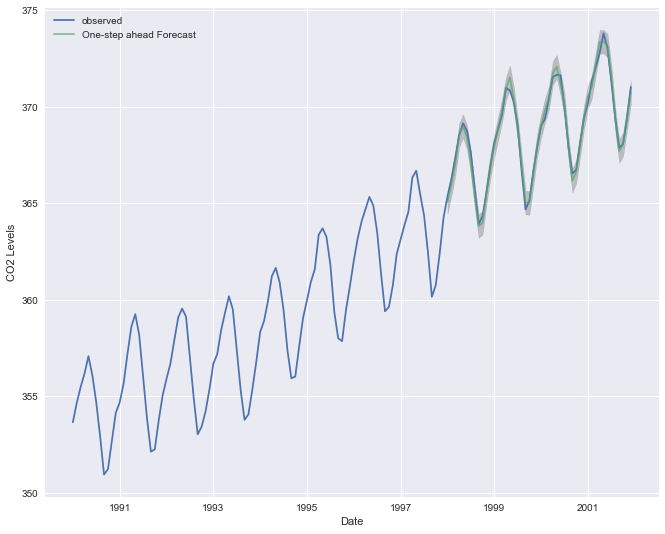

In [20]:
ax = y['1990':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7)

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('CO2 Levels')
plt.legend()

plt.show()

Overall, our forecasts align with the true values very well, showing an overall increase trend.

It is also useful to quantify the accuracy of our forecasts. We will use the MSE (Mean Squared Error), which summarizes the average error of our forecasts. 

For each predicted value, we compute its distance to the true value and square the result. 

The results need to be squared so that positive/negative differences do not cancel each other out when we compute the overall mean.

In [21]:
y_forecasted = pred.predicted_mean
y_truth = y['1998-01-01':]

# Compute the mean square error
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 0.07


The MSE of our one-step ahead forecasts yields a value of 0.07, which is very low as it is close to 0. 

An MSE of 0 would that the estimator is predicting observations of the parameter with perfect accuracy, which would be an ideal scenario but it not typically possible.

However, a better representation of our true predictive power can be obtained using dynamic forecasts. 

In this case, we only use information from the time series up to a certain point, and after that, forecasts are generated using values from previous forecasted time points.

In the code chunk below, we specify to start computing the dynamic forecasts and confidence intervals from January 1998 onwards.

In [22]:
pred_dynamic = results.get_prediction(start=pd.to_datetime('1998-01-01'), dynamic=True, full_results=True)
pred_dynamic_ci = pred_dynamic.conf_int()

Plotting the observed and forecasted values of the time series, we see that the overall forecasts are accurate even when using dynamic forecasts. 

All forecasted values (red line) match pretty closely to the ground truth (blue line), and are well within the confidence intervals of our forecast.

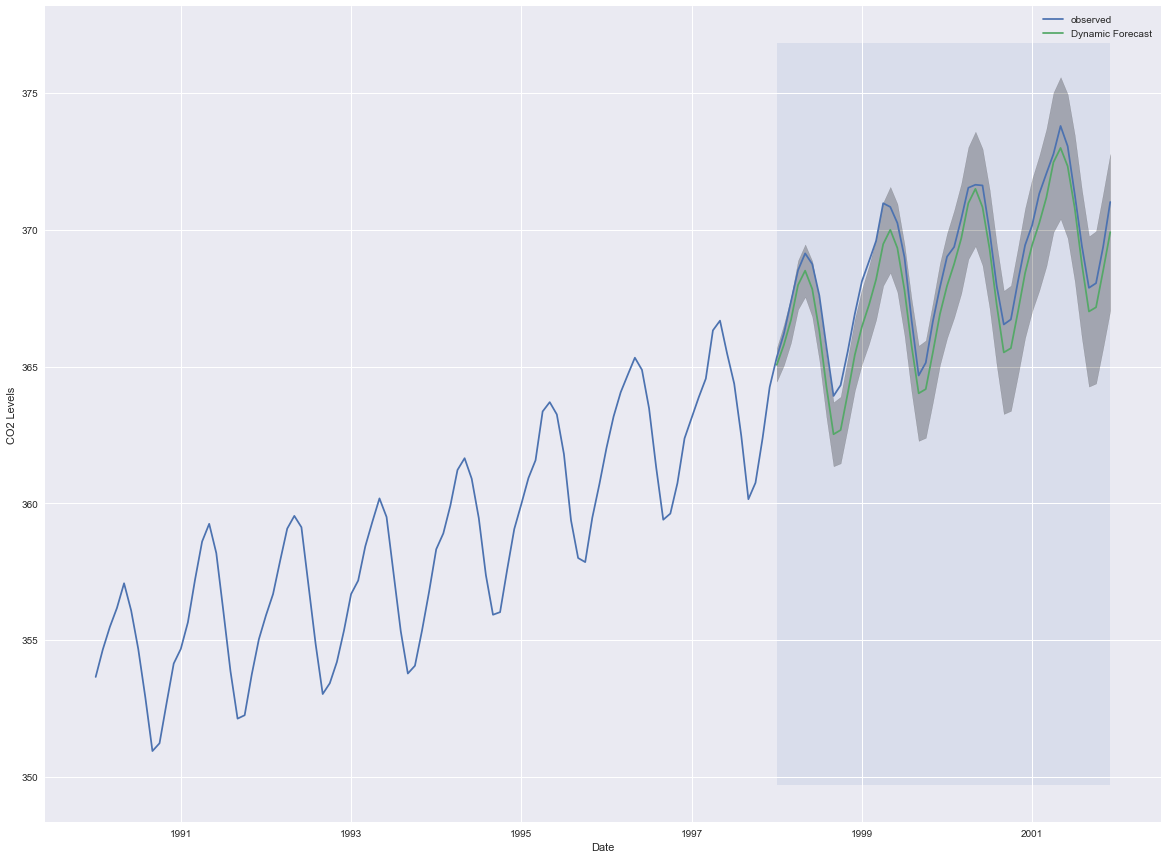

In [23]:
ax = y['1990':].plot(label='observed', figsize=(20, 15))
pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

ax.fill_between(pred_dynamic_ci.index,
                pred_dynamic_ci.iloc[:, 0],
                pred_dynamic_ci.iloc[:, 1], color='k', alpha=.25)

ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('1998-01-01'), y.index[-1],
                 alpha=.1, zorder=-1)

ax.set_xlabel('Date')
ax.set_ylabel('CO2 Levels')

plt.legend()
plt.show()

Once again, we quantify the predictive performance of our forecasts by computing the MSE:

In [24]:
# Extract the predicted and true values of our time series
y_forecasted = pred_dynamic.predicted_mean
y_truth = y['1998-01-01':]

# Compute the mean square error
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 1.01


The predicted values obtained from the dynamic forecasts yield an MSE of 1.01. 

This is slightly higher than the one-step ahead, which is to be expected given that we are relying on less historical data from the time series.

Both the one-step ahead and dynamic forecasts confirm that this time series model is valid. 

However, much of the interest around time series forecasting is the ability to forecast future values way ahead in time.

#### Step 7 — Producing and Visualizing Forecasts

The get_forecast() attribute of our time series object can compute forecasted values for a specified number of steps ahead.

In [25]:
# Get forecast 500 steps ahead in future
pred_uc = results.get_forecast(steps=500)

# Get confidence intervals of forecasts
pred_ci = pred_uc.conf_int()

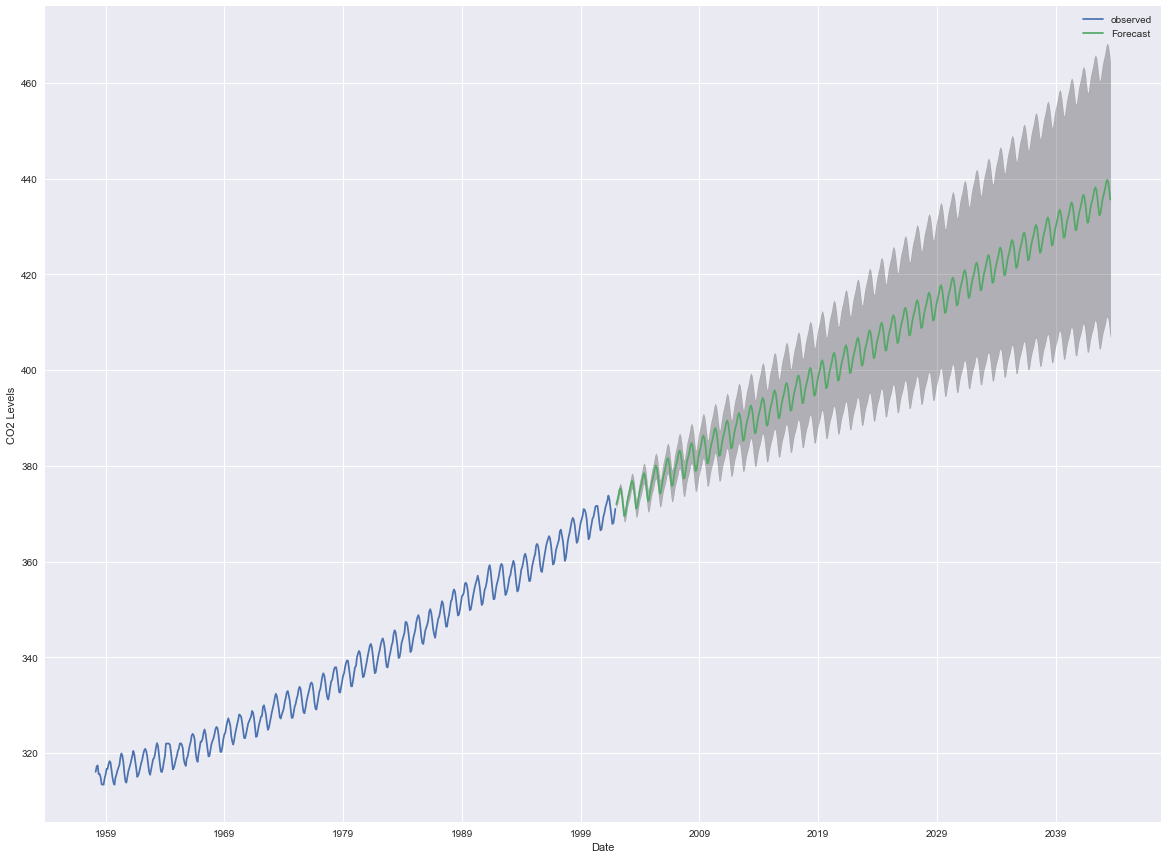

In [26]:
ax = y.plot(label='observed', figsize=(20, 15))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('CO2 Levels')

plt.legend()
plt.show()